In [2]:
#wget- get the image
#O is for setting the flag(defines the name and overwrite with refresh)
! wget https://antidote.cloud/f/467bc9fab4da4d2da65f/?dl=1 -O img.jpg

--2024-01-19 19:06:31--  https://antidote.cloud/f/467bc9fab4da4d2da65f/?dl=1
Resolving antidote.cloud (antidote.cloud)... 193.30.122.219
Connecting to antidote.cloud (antidote.cloud)|193.30.122.219|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://antidote.cloud/seafhttp/files/1e8a2486-2cc5-48a5-b38c-74db244e59d9/img.jpg [following]
--2024-01-19 19:06:32--  https://antidote.cloud/seafhttp/files/1e8a2486-2cc5-48a5-b38c-74db244e59d9/img.jpg
Reusing existing connection to antidote.cloud:443.
HTTP request sent, awaiting response... 200 OK
Length: 75466 (74K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  73.70K  --.-KB/s    in 0.1s    

2024-01-19 19:06:32 (724 KB/s) - ‘img.jpg’ saved [75466/75466]



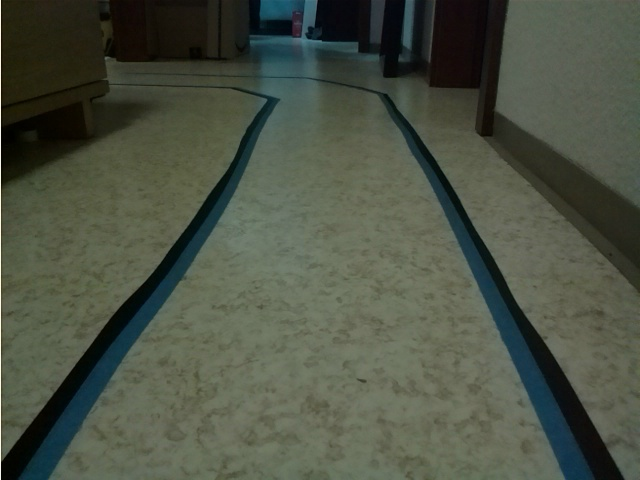

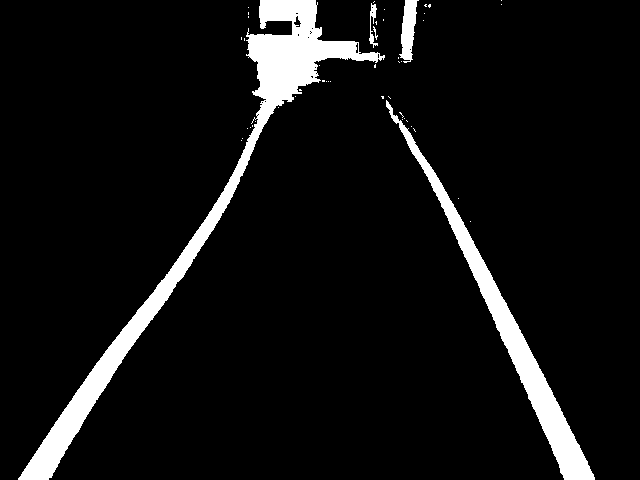

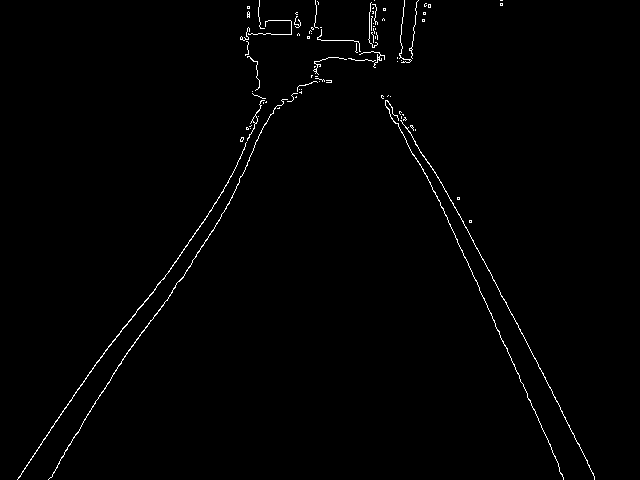

In [3]:
#Canny edge the image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
img=cv2.imread('img.jpg')
cv2_imshow(img)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([80,60,29])
upper_blue = np.array([179,255,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)
cv2_imshow(mask)
edges = cv2.Canny(mask, 100, 200)
cv2_imshow(edges)

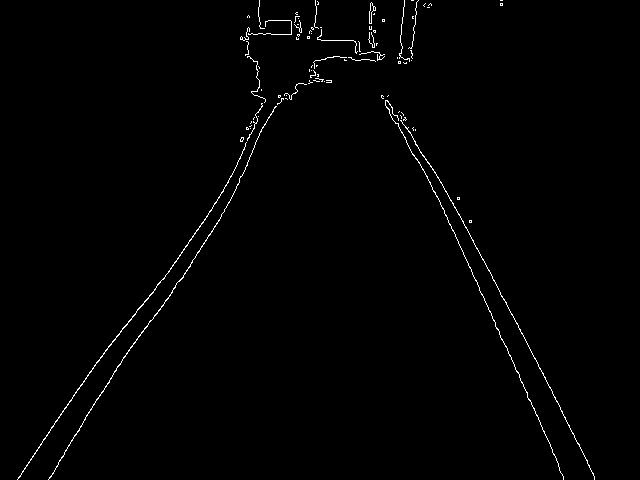

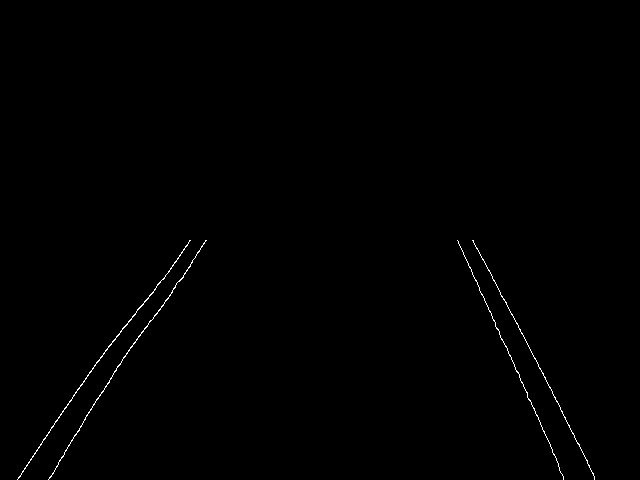

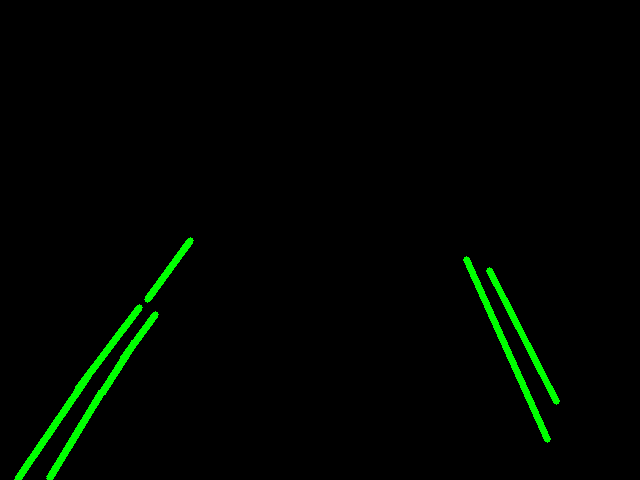

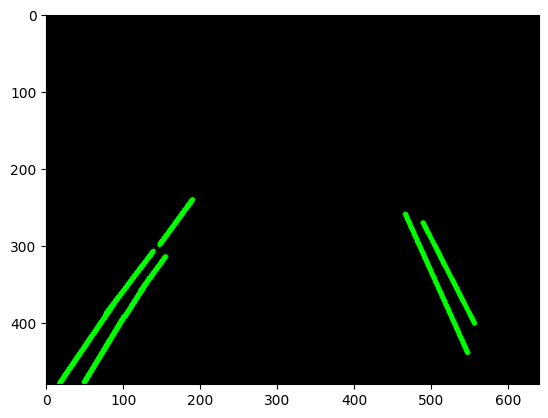

In [ ]:
#canny edge the image.
#considering the region of interest(making the upper part of the image black because the car should not predict the future).
#Hough transform to connect the boundries and give a proper solid boundry.
import cv2
import numpy as np
import os
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

img = cv2.imread('img.jpg')

class im2angle:
    def __init__(self, img):
        self.frame = img
        self.height, self.width, _ = img.shape

    def edge_detection(self):
        # filter for blue lane lines
        # (hMin = 80 , sMin = 65, vMin = 29), (hMax = 197 , sMax = 255, vMax = 255)
        hsv = cv2.cvtColor(self.frame, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([80, 65, 29])
        upper_blue = np.array([179, 255, 255])
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        edges = cv2.Canny(mask, 200, 400)
        return edges

    def region_of_interest(self, edges):
        # only focus bottom half of the screen
        polygon = np.array([[
            (0, self.height * 1 / 2),
            (self.width, self.height * 1 / 2),
            (self.width, self.height),
            (0, self.height),
        ]], np.int32)

        mask = np.zeros_like(edges)
        img = cv2.fillPoly(mask, polygon, 255)
        cropped_edges = cv2.bitwise_and(edges, mask)
        return cropped_edges

    def hough_transform(self, cropped_edges):
        lines = cv2.HoughLinesP(cropped_edges, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
        line_image = np.zeros_like(self.frame)
        if lines is not None:
            for line in lines:
                for x1, y1, x2, y2 in line:
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
        return line_image

    def show_image(self, frame):
        cv2_imshow(frame)

foo = im2angle(img)
edges = foo.edge_detection()
foo.show_image(edges)
croped = foo.region_of_interest(edges)
foo.show_image(croped)

# Integrate Hough transform into Code 1
hough_result = foo.hough_transform(croped)
foo.show_image(hough_result)
plt.imshow(hough_result)
plt.show()


In [7]:
#final code put into rasberry pi, we get an angle 90 degree as the output which shows that the car has to go straight when no blue colour is encountered.
import cv2
import numpy as np
import os
import math

class CalcAngle:

  frame = None

  def __init__(self, height, width, lower_blue, upper_blue):
    self.lower_blue = lower_blue
    self.upper_blue = upper_blue
    self.height = height
    self.width = width
    self.mid = int(self.width / 2 * (1))
    self.boundary = 1/2
    self.left_region_boundary = self.width * (1 - self.boundary)  # left lane line segment should be on left 2/3 of the screen
    self.right_region_boundary = self.width * self.boundary # right lane line segment should be on left 2/3 of the screen


  def detect_edges(self, frame):
    # filter for blue lane lines
    # (hMin = 75 , sMin = 0, vMin = 50), (hMax = 119 , sMax = 255, vMax = 255)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, self.lower_blue, self.upper_blue)
    blur = cv2.GaussianBlur(mask,(5, 5), 0)
    edges = cv2.Canny(mask, 200, 400)
    return edges

  def detect_line_segments(self, cropped_edges):
      # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
      rho = 1  # distance precision in pixel, i.e. 1 pixel
      angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
      min_threshold = 25  # minimal of votes
      line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold,
                                      np.array([]), minLineLength=20, maxLineGap=14)
      return line_segments

  def region_of_interest(self, edges):
      height, width = edges.shape
      mask = np.zeros_like(edges)

      # only focus bottom half of the screen
      polygon = np.array([[
          (0, height * 1 / 2),
          (width, height * 1 / 2),
          (width, height),
          (0, height),
      ]], np.int32)

      cv2.fillPoly(mask, polygon, 255)
      cropped_edges = cv2.bitwise_and(edges, mask)
      return cropped_edges

  def make_points(self, fit_average):
      slope, intercept = fit_average
      y1 = self.height  # bottom of the frame
      y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

      # bound the coordinates within the frame
      x1 = max(-self.width, min(2 * self.width, int((y1 - intercept) / slope)))
      x2 = max(-self.width, min(2 * self.width, int((y2 - intercept) / slope)))
      return [[x1, y1, x2, y2]]


  def average_slope_intercept(self, lane_lines):
    left_fit = []
    right_fit = []
    lines = []
    for lane_line in lane_lines:
      for x1, y1, x2, y2 in lane_line:
        if x1 == x2:
          continue
        fit = np.polyfit((x1, x2), (y1, y2), 1)
        slope = fit[0]
        intercept = fit[1]
        if slope < 0:
          if x1 < self.left_region_boundary and x2 < self.left_region_boundary:
              left_fit.append((slope, intercept))
        else:
          if x1 > self.right_region_boundary and x2 > self.right_region_boundary:
              right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)

    if len(left_fit) > 0:
        lines.append(self.make_points(left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)

    if len(right_fit) > 0:
        lines.append(self.make_points(right_fit_average))

    return lines

  def compute_steering_angle(self, lines):
      """ Find the steering angle based on lane line coordinate
          We assume that camera is calibrated to point to dead center
      """

      if len(lines) == 0:
          return 90

      if len(lines) == 1:
          x1, _, x2, _ = lines[0][0]
          x_offset = x2 - x1
      else:

          _, _, left_x2, _ = lines[0][0]
          _, _, right_x2, _ = lines[1][0]

          x_offset = (left_x2 + right_x2) / 2 - self.mid

      # find the steering angle, which is angle between navigation direction to end of center line
      y_offset = int(self.height / 2)

      angle_to_mid_deg = int(math.atan(x_offset / y_offset) * 180.0 / math.pi)  # angle (in degrees) to center vertical line

      steering_angle = 90 - angle_to_mid_deg # this is the steering angle needed

      return steering_angle

  def set_frame(self, frame):
    self.frame = frame

  def get_angle(self, frame):
    self.set_frame(frame)
    lane_lines = self.detect_line_segments(self.region_of_interest(self.detect_edges(frame)))
    if lane_lines is None:
      return 90
    lines = self.average_slope_intercept(lane_lines)
    return self.compute_steering_angle(lines)


if __name__ == "__main__":
  frame = cv2.imread('img.jpg')
  height, width, _ = frame.shape
  lower_blue = np.array([26, 207, 39])
  upper_blue = np.array([179, 255, 255])
  print(CalcAngle(height, width, lower_blue, upper_blue ).get_angle(frame))


90
